# K-Means Clustering

## Installing libraries

In [1]:
import pandas as pd
import numpy as np
import re
import mpmath
from collections import Counter
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.colors

## Data Import and Cleansing

In [2]:
traffic_data = pd.read_excel('cleaned_data_using_content.xlsx')
#selecting just records assosciated to accidents
accident_data = traffic_data[traffic_data['accident_flag'] == 1]

In [3]:
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375 entries, 0 to 430
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   source                       375 non-null    object        
 1   published_date               375 non-null    datetime64[ns]
 2   title                        375 non-null    object        
 3   content                      375 non-null    object        
 4   hospital flag                375 non-null    bool          
 5   date of incident             334 non-null    datetime64[ns]
 6   weekday of incident          334 non-null    object        
 7   time of incident             279 non-null    float64       
 8   weekday_mentioned            222 non-null    object        
 9   time_ampm                    174 non-null    object        
 10  city_id                      320 non-null    float64       
 11  city                         320 non-null    objec

In [4]:
accident_data.head(10)

,source,published_date,title,content,hospital flag,date of incident,weekday of incident,time of incident,weekday_mentioned,time_ampm,...,bike_flag,car_flag,gender_M_flag,gender_F_flag,heavy_vehicle_flag,pedestrian_flag,illegal_flag,traffic_flag,control_flag,vehicle_count
0,police_report,2025-10-09,Collision between a car and a motorbike in Żur...,"Today, at around 0930hrs, the Police were info...",True,2025-10-09,Thursday,930.0,NaN,NaN,...,0,1,1,1,0,0,0,1,0,2
1,police_report,2025-06-20,Car-motorcycle traffic accident,"Yesterday, at around 1830hrs, the Police were ...",True,2025-06-19,Thursday,1830.0,NaN,NaN,...,0,1,1,0,0,0,0,1,0,2
2,police_report,2025-05-12,Car-motorcycle collision in Ħal Qormi,"Today, at around 0800hrs, the Police were info...",True,2025-05-12,Monday,800.0,NaN,NaN,...,0,1,1,0,0,0,0,1,0,2
3,police_report,2025-07-30,Collision between motorcycle and car in Għaxaq,"Yesterday, at around 1800hrs, the Police were ...",True,2025-07-29,Tuesday,1800.0,NaN,NaN,...,0,1,1,0,0,0,0,1,0,2
4,police_report,2025-04-07,Car-motorcycle collision,"Yesterday, at around quarter to nine in the ev...",True,2025-04-06,Sunday,2045.0,NaN,NaN,...,0,1,1,0,0,0,0,1,0,2
5,police_report,2025-04-16,Traffic accident in Marsa,"Yesterday, at around ten minutes to nine in th...",True,2025-04-15,Tuesday,850.0,NaN,NaN,...,0,1,1,0,1,0,0,1,0,3
6,police_report,2025-07-23,Van-car collision in Lija,"Today, at around 1030hrs, the Police were info...",True,2025-07-23,Wednesday,1030.0,NaN,NaN,...,0,1,1,1,1,0,0,1,0,3
7,police_report,2025-08-03,Zejtun traffic accident,"This morning, at around 0815 hrs, the Police w...",True,2025-08-03,Sunday,815.0,NaN,NaN,...,0,1,1,1,0,0,0,1,0,2
8,police_report,2025-06-14,Motorcyclist injured in traffic accident,"On wednesday the 11th of June, at around four ...",True,2025-06-11,Wednesday,1545.0,wednesday,NaN,...,0,1,1,0,0,0,0,1,0,2
9,police_report,2024-12-28,Number of persons hospitalised following Żabba...,"Today, at around quarter past nine in the morn...",True,2024-12-28,Saturday,915.0,NaN,NaN,...,0,0,1,1,0,0,0,0,1,0


In [5]:
first_article = min(accident_data['published_date'])
last_article = max(accident_data['published_date'])

In [6]:
print("The oldest article was published on the  ", first_article, "  and the newest article was published on the  ", last_article)

The oldest article was published on the   2024-12-07 00:00:00   and the newest article was published on the   2025-10-14 00:00:00


In [7]:
#adding in the month that the traffic accident took place
accident_data['month'] = pd.DatetimeIndex(accident_data['date of incident']).month

/var/folders/0x/640dcwld7gb2lqvk47n27b4h0000gn/T/ipykernel_2474/457572768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_data['month'] = pd.DatetimeIndex(accident_data['date of incident']).month


In [8]:
#creating a subset to work with for the KMeans
accident_df = accident_data[['source','date of incident','time of incident','weekday of incident','city','latitude','longitude',
                             'month','weather_category','accident_flag','hospital_flag','injury_flag','fatal_flag','severe_flag','minor_flag']].copy()
accident_df.rename(columns={'source':'source','date of incident': 'date','time of incident':'time', 'weekday of incident': 'weekday',
                           'city': 'city','latitude':'latitude','longitude':'longitude','month':'month','weather_category':'weather','accident_flag':'accident','hospital_flag':'hospital',
                            'injury_flag':'injury','fatal_flag':'fatal','severe_flag':'severe',
                           'minor_flag':'minor'}, inplace=True)

In [9]:
accident_df.head()

,source,date,time,weekday,city,latitude,longitude,month,weather,accident,hospital,injury,fatal,severe,minor
0,police_report,2025-10-09,930.0,Thursday,Żurrieq,35.8292,14.4758,10.0,cloudy,1,1,1,0,1,0
1,police_report,2025-06-19,1830.0,Thursday,Gudja,35.8483,14.5025,6.0,cloudy,1,1,1,0,1,0
2,police_report,2025-05-12,800.0,Monday,Qormi,35.8794,14.4722,5.0,cloudy,1,1,1,0,1,0
3,police_report,2025-07-29,1800.0,Tuesday,Għaxaq,35.8483,14.5172,7.0,cloudy,1,1,1,0,1,0
4,police_report,2025-04-06,2045.0,Sunday,Rabat,35.8817,14.3989,4.0,rain/drizzle,1,1,1,0,1,0


In [10]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375 entries, 0 to 430
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source     375 non-null    object        
 1   date       334 non-null    datetime64[ns]
 2   time       279 non-null    float64       
 3   weekday    334 non-null    object        
 4   city       320 non-null    object        
 5   latitude   320 non-null    float64       
 6   longitude  320 non-null    float64       
 7   month      334 non-null    float64       
 8   weather    289 non-null    object        
 9   accident   375 non-null    int64         
 10  hospital   375 non-null    int64         
 11  injury     375 non-null    int64         
 12  fatal      375 non-null    int64         
 13  severe     375 non-null    int64         
 14  minor      375 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(4)
memory usage: 46.9+ KB


In [11]:
#cleaning up
filtered_df = accident_df[accident_df['city'].notnull()]
filtered_df = filtered_df[accident_df['weekday'].notnull()]
#filling na time with mean
filtered_df['time'].fillna((filtered_df['time'].mean()), inplace=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 426
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source     289 non-null    object        
 1   date       289 non-null    datetime64[ns]
 2   time       289 non-null    float64       
 3   weekday    289 non-null    object        
 4   city       289 non-null    object        
 5   latitude   289 non-null    float64       
 6   longitude  289 non-null    float64       
 7   month      289 non-null    float64       
 8   weather    289 non-null    object        
 9   accident   289 non-null    int64         
 10  hospital   289 non-null    int64         
 11  injury     289 non-null    int64         
 12  fatal      289 non-null    int64         
 13  severe     289 non-null    int64         
 14  minor      289 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(4)
memory usage: 36.1+ KB


/var/folders/0x/640dcwld7gb2lqvk47n27b4h0000gn/T/ipykernel_2474/3360211176.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[accident_df['weekday'].notnull()]
/var/folders/0x/640dcwld7gb2lqvk47n27b4h0000gn/T/ipykernel_2474/3360211176.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['time'].fillna((filtered_df['time'].mean()), inplace=True)


In [12]:
filtered_df.head()

,source,date,time,weekday,city,latitude,longitude,month,weather,accident,hospital,injury,fatal,severe,minor
0,police_report,2025-10-09,930.0,Thursday,Żurrieq,35.8292,14.4758,10.0,cloudy,1,1,1,0,1,0
1,police_report,2025-06-19,1830.0,Thursday,Gudja,35.8483,14.5025,6.0,cloudy,1,1,1,0,1,0
2,police_report,2025-05-12,800.0,Monday,Qormi,35.8794,14.4722,5.0,cloudy,1,1,1,0,1,0
3,police_report,2025-07-29,1800.0,Tuesday,Għaxaq,35.8483,14.5172,7.0,cloudy,1,1,1,0,1,0
4,police_report,2025-04-06,2045.0,Sunday,Rabat,35.8817,14.3989,4.0,rain/drizzle,1,1,1,0,1,0


In [13]:
#for a cleaner look
#we see that some records are repeated between th epolice report
#and the press releases
filtered_df.sort_values(by='date')

,source,date,time,weekday,city,latitude,longitude,month,weather,accident,hospital,injury,fatal,severe,minor
111,news_article,2024-12-04,1700.000000,Wednesday,San Ġwann,35.9094,14.4786,12.0,rain/drizzle,1,0,1,0,1,0
82,police_report,2024-12-11,1115.000000,Wednesday,Naxxar,35.9150,14.4447,12.0,cloudy,1,1,1,0,1,0
117,news_article,2024-12-11,1303.219512,Wednesday,Mellieħa,35.9564,14.3664,12.0,cloudy,1,1,0,1,1,0
100,police_report,2024-12-11,1700.000000,Wednesday,Saint Paul’s Bay,35.9483,14.4017,12.0,cloudy,1,1,1,1,1,0
114,news_article,2024-12-11,1300.000000,Wednesday,Saint Paul’s Bay,35.9483,14.4017,12.0,cloudy,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,news_article,2025-10-07,1303.219512,Tuesday,Paola,35.8728,14.5075,10.0,sunny/clear,1,0,0,0,0,0
423,news_article,2025-10-09,1303.219512,Thursday,Paola,35.8728,14.5075,10.0,cloudy,1,0,0,0,0,1
0,police_report,2025-10-09,930.000000,Thursday,Żurrieq,35.8292,14.4758,10.0,cloudy,1,1,1,0,1,0
424,news_article,2025-10-09,930.000000,Thursday,Żurrieq,35.8292,14.4758,10.0,cloudy,1,1,1,0,1,0


In [14]:
#creating an arbitrary period where we have the city and the month
#making them to string since this is the only way this will work
filtered_df["period"] = filtered_df["city"].astype(str) + filtered_df["month"].astype(str)

In [15]:
#mapping categorical variables
#weekday
filtered_df['weekday'] = filtered_df['weekday'].map({'Monday': 1,'Tuesday': 2,'Wednesday': 3,
                                                     'Thursday': 4,'Friday': 5,'Saturday': 6,
                                                     'Sunday': 7})
#weather category
filtered_df['weather'] = filtered_df['weather'].map({'cloudy': 1,'sunny/clear': 2,'rain/drizzle': 3})
#cities to regions
#Southern Harbour District = 1, Northern Harbour District = 2, South Eastern District = 3, Western Dustrict = 4, Northern District = 5, Gozo & COmino District = 6
filtered_df['regions'] = filtered_df['city'].map({'Naxxar': 5,'Marsa': 1,'Saint Paul’s Bay': 5,'Birkirkara': 2,
	'Żebbuġ': 4,'Sliema': 2,'Żejtun': 3,'Attard': 4, 'Paola': 1,'Żabbar': 1,'Floriana': 1,'San Ġwann': 2,'Mellieħa': 5,
	'Rabat': 4,'Fgura': 1,'Imsida': 2,'Santa Venera': 2,'Luqa': 1,'Siġġiewi': 4,'Gżira': 2,'Valletta': 1,'Marsaskala': 3,
	'Pembroke': 2,'Victoria': 6,'Gudja': 3,'Qormi': 2,'Lija': 4,'Xewkija': 6,'Birżebbuġa': 3,'Mosta': 5,'Mġarr': 5,
	'Ħamrun': 2,'Żurrieq': 3,'Pietà': 2,'Għajnsielem': 6,'Tarxien': 1,'Marsaxlokk': 3,'Għaxaq': 3,'Imtarfa': 4,'Iklin': 4,
	'Qala': 6,'Xagħra': 6,'Swieqi': 2,'Kirkop': 3,'Buġibba': 5,'Senglea': 1,'Sannat': 6,'Cospicua': 1,'Balzan': 4,'Ta’ Xbiex': 2,
	'Għarb': 6,'Vittoriosa': 6,'Nadur': 6,'Qrendi': 3,'Imqabba': 3})

In [16]:
filtered_df.head(15)

,source,date,time,weekday,city,latitude,longitude,month,weather,accident,hospital,injury,fatal,severe,minor,period,regions
0,police_report,2025-10-09,930.0,4,Żurrieq,35.8292,14.4758,10.0,1,1,1,1,0,1,0,Żurrieq10.0,3
1,police_report,2025-06-19,1830.0,4,Gudja,35.8483,14.5025,6.0,1,1,1,1,0,1,0,Gudja6.0,3
2,police_report,2025-05-12,800.0,1,Qormi,35.8794,14.4722,5.0,1,1,1,1,0,1,0,Qormi5.0,2
3,police_report,2025-07-29,1800.0,2,Għaxaq,35.8483,14.5172,7.0,1,1,1,1,0,1,0,Għaxaq7.0,3
4,police_report,2025-04-06,2045.0,7,Rabat,35.8817,14.3989,4.0,3,1,1,1,0,1,0,Rabat4.0,4
5,police_report,2025-04-15,850.0,2,Marsa,35.8833,14.4947,4.0,3,1,1,1,0,1,0,Marsa4.0,1
6,police_report,2025-07-23,1030.0,3,Lija,35.9014,14.4472,7.0,2,1,1,1,1,1,1,Lija7.0,4
7,police_report,2025-08-03,815.0,7,Żejtun,35.8556,14.5333,8.0,1,1,1,1,0,1,0,Żejtun8.0,3
8,police_report,2025-06-11,1545.0,3,Naxxar,35.9150,14.4447,6.0,1,1,1,1,0,1,0,Naxxar6.0,5
9,police_report,2024-12-28,915.0,6,Żabbar,35.8772,14.5381,12.0,3,1,1,1,1,1,1,Żabbar12.0,1


## EDA

In [17]:
day = Counter(filtered_df['weekday'])
day

Counter({4: 52, 3: 50, 7: 44, 5: 40, 1: 36, 2: 34, 6: 33})

In [18]:
w_cat = Counter(filtered_df['weather'])
w_cat

Counter({1: 100, 2: 96, 3: 93})

In [19]:
cities = Counter(filtered_df['city'])
cities

Counter({'Naxxar': 20,
         'Marsa': 18,
         'Saint Paul’s Bay': 14,
         'Birkirkara': 12,
         'Żebbuġ': 11,
         'Sliema': 11,
         'Żejtun': 10,
         'Attard': 10,
         'Paola': 9,
         'Żabbar': 8,
         'Floriana': 8,
         'San Ġwann': 8,
         'Mellieħa': 8,
         'Rabat': 7,
         'Fgura': 7,
         'Imsida': 7,
         'Santa Venera': 7,
         'Luqa': 6,
         'Siġġiewi': 6,
         'Gżira': 6,
         'Valletta': 6,
         'Marsaskala': 5,
         'Pembroke': 5,
         'Victoria': 5,
         'Gudja': 4,
         'Qormi': 4,
         'Lija': 4,
         'Xewkija': 4,
         'Birżebbuġa': 4,
         'Mosta': 4,
         'Mġarr': 4,
         'Ħamrun': 4,
         'Żurrieq': 3,
         'Pietà': 3,
         'Għajnsielem': 3,
         'Tarxien': 3,
         'Marsaxlokk': 3,
         'Għaxaq': 2,
         'Imtarfa': 2,
         'Iklin': 2,
         'Qala': 2,
         'Xagħra': 2,
         'Swieqi': 2,
       

In [20]:
regions = Counter(filtered_df['regions'])
regions

Counter({2: 70, 1: 68, 5: 52, 4: 43, 3: 35, 6: 21})

In [21]:
months = Counter(filtered_df['month'])
months

Counter({8.0: 50,
         7.0: 38,
         2.0: 28,
         9.0: 27,
         12.0: 26,
         4.0: 25,
         6.0: 24,
         1.0: 23,
         5.0: 22,
         10.0: 14,
         3.0: 12})

In [22]:
time = Counter(filtered_df['time'])
time

Counter({1303.219512195122: 43,
         2100.0: 10,
         1330.0: 9,
         800.0: 8,
         1800.0: 8,
         1015.0: 8,
         1530.0: 8,
         530.0: 8,
         930.0: 7,
         1830.0: 7,
         1315.0: 7,
         1100.0: 7,
         1700.0: 7,
         745.0: 6,
         900.0: 6,
         1130.0: 6,
         1300.0: 5,
         2200.0: 5,
         730.0: 5,
         1930.0: 5,
         1415.0: 5,
         1000.0: 4,
         1430.0: 4,
         1745.0: 4,
         1600.0: 4,
         1230.0: 4,
         2045.0: 3,
         1030.0: 3,
         830.0: 3,
         1515.0: 3,
         2300.0: 3,
         945.0: 3,
         100.0: 3,
         1900.0: 3,
         1200.0: 3,
         630.0: 3,
         2000.0: 3,
         1730.0: 3,
         850.0: 2,
         815.0: 2,
         915.0: 2,
         1945.0: 2,
         2330.0: 2,
         2115.0: 2,
         500.0: 2,
         1215.0: 2,
         200.0: 2,
         715.0: 2,
         430.0: 2,
         1815.0: 2,
    

In [23]:
source = Counter(filtered_df['source'])
source

Counter({'news_article': 182, 'police_report': 107})

## Aggregation wrt. the city column

In [24]:
new_df = filtered_df.groupby('city', as_index=False)[['accident','hospital','injury','fatal',
'severe','minor']].sum()
new_df['regions'] = new_df['city'].map({'Naxxar': 5,'Marsa': 1,'Saint Paul’s Bay': 5,'Birkirkara': 2,
	'Żebbuġ': 4,'Sliema': 2,'Żejtun': 3,'Attard': 4, 'Paola': 1,'Żabbar': 1,'Floriana': 1,'San Ġwann': 2,'Mellieħa': 5,
	'Rabat': 4,'Fgura': 1,'Imsida': 2,'Santa Venera': 2,'Luqa': 1,'Siġġiewi': 4,'Gżira': 2,'Valletta': 1,'Marsaskala': 3,
	'Pembroke': 2,'Victoria': 6,'Gudja': 3,'Qormi': 2,'Lija': 4,'Xewkija': 6,'Birżebbuġa': 3,'Mosta': 5,'Mġarr': 5,
	'Ħamrun': 2,'Żurrieq': 3,'Pietà': 2,'Għajnsielem': 6,'Tarxien': 1,'Marsaxlokk': 3,'Għaxaq': 3,'Imtarfa': 4,'Iklin': 4,
	'Qala': 6,'Xagħra': 6,'Swieqi': 2,'Kirkop': 3,'Buġibba': 5,'Senglea': 1,'Sannat': 6,'Cospicua': 1,'Balzan': 4,'Ta’ Xbiex': 2,
	'Għarb': 6,'Vittoriosa': 6,'Nadur': 6,'Qrendi': 3,'Imqabba': 3})
new_df.head(20)

,city,accident,hospital,injury,fatal,severe,minor,regions
0,Attard,10,6,6,6,7,1,4
1,Balzan,1,1,1,0,1,0,4
2,Birkirkara,12,9,9,5,12,0,2
3,Birżebbuġa,4,2,4,0,4,0,3
4,Buġibba,2,2,1,0,2,0,5
5,Cospicua,1,1,1,0,1,0,1
6,Fgura,7,6,7,3,7,0,1
7,Floriana,8,8,6,3,8,0,1
8,Gudja,4,4,4,0,4,1,3
9,Għajnsielem,3,3,3,1,3,1,6


In [25]:
cities = filtered_df[['city','longitude','latitude']]
cities.head(20)
unique_cities = cities.drop_duplicates()
sorted_unique_cities = unique_cities.sort_values(by='city')
sorted_unique_cities.head(20)
result = pd.merge(new_df, sorted_unique_cities, on='city')
result.head(20)
new_df = result
new_df.head(20)

,city,accident,hospital,injury,fatal,severe,minor,regions,longitude,latitude
0,Attard,10,6,6,6,7,1,4,14.4383,35.8928
1,Balzan,1,1,1,0,1,0,4,14.4533,35.8981
2,Birkirkara,12,9,9,5,12,0,2,14.4625,35.8967
3,Birżebbuġa,4,2,4,0,4,0,3,14.5281,35.8256
4,Buġibba,2,2,1,0,2,0,5,14.4110,35.9484
5,Cospicua,1,1,1,0,1,0,1,14.5222,35.8822
6,Fgura,7,6,7,3,7,0,1,14.5228,35.8725
7,Floriana,8,8,6,3,8,0,1,14.5058,35.8933
8,Gudja,4,4,4,0,4,1,3,14.5025,35.8483
9,Għajnsielem,3,3,3,1,3,1,6,14.2903,36.0269


## Visualisations wrt. the city column

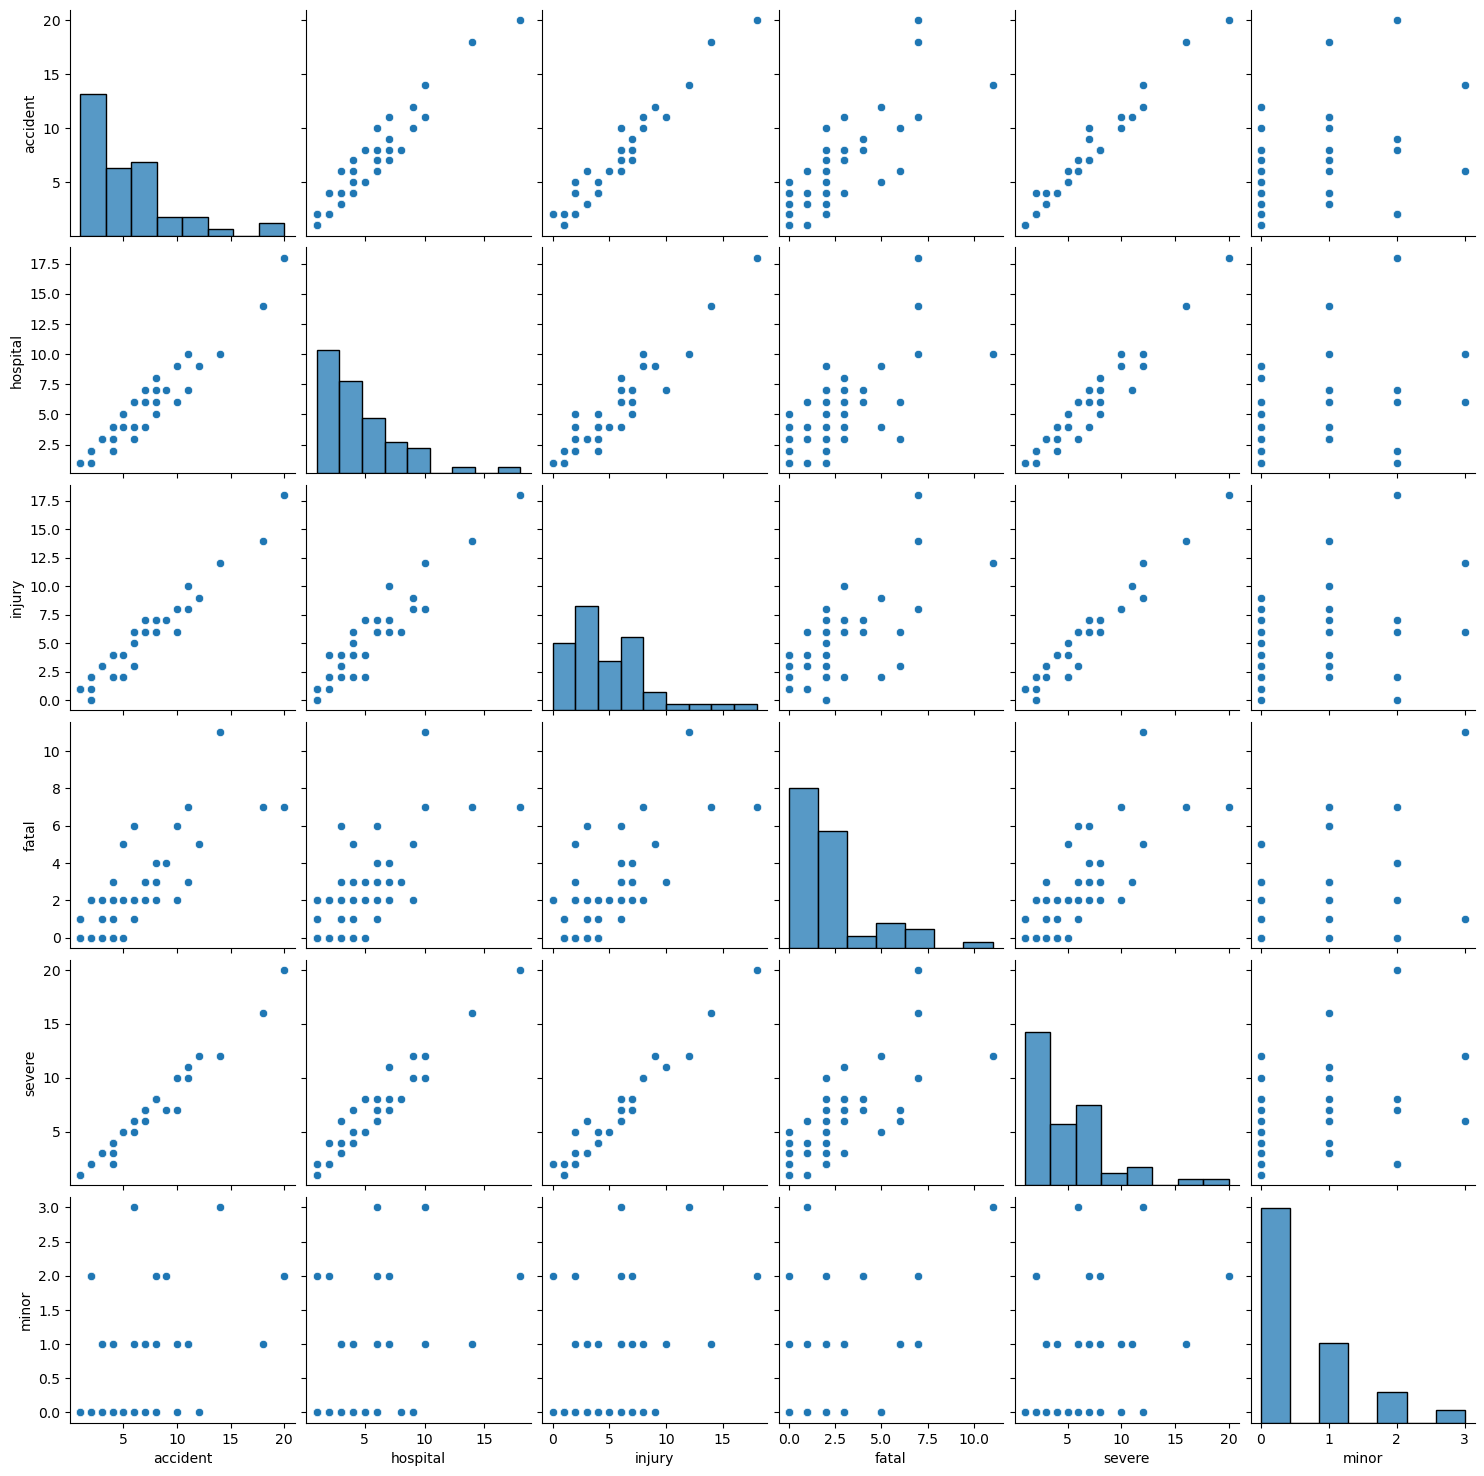

In [26]:
#any visual clusters
sns.pairplot(new_df[['accident','hospital','injury','fatal','severe','minor']])
plt.show()

## K-Means wrt. the city column

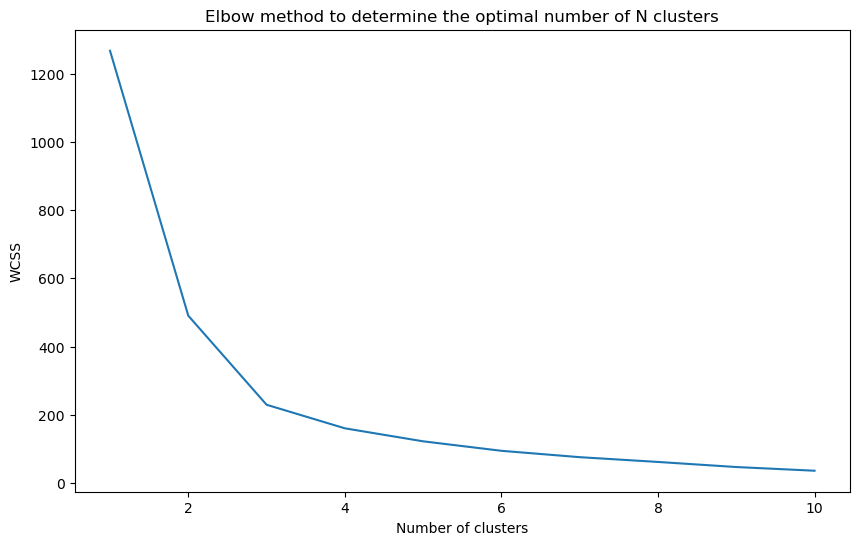

In [27]:
#x,y
X = new_df[['accident','fatal']]
wcss = []

for i in range(1,11):
	kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
	kmeans.fit(X)
	wcss.append(kmeans.inertia_)


plt.figure(figsize=(10,6))
plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to determine the optimal number of N clusters')
plt.show()

In [28]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
#to get the respective cluster number
new_df['Cluster'] = y_kmeans
new_df.head(20)

,city,accident,hospital,injury,fatal,severe,minor,regions,longitude,latitude,Cluster
0,Attard,10,6,6,6,7,1,4,14.4383,35.8928,0
1,Balzan,1,1,1,0,1,0,4,14.4533,35.8981,1
2,Birkirkara,12,9,9,5,12,0,2,14.4625,35.8967,0
3,Birżebbuġa,4,2,4,0,4,0,3,14.5281,35.8256,1
4,Buġibba,2,2,1,0,2,0,5,14.4110,35.9484,1
5,Cospicua,1,1,1,0,1,0,1,14.5222,35.8822,1
6,Fgura,7,6,7,3,7,0,1,14.5228,35.8725,2
7,Floriana,8,8,6,3,8,0,1,14.5058,35.8933,2
8,Gudja,4,4,4,0,4,1,3,14.5025,35.8483,1
9,Għajnsielem,3,3,3,1,3,1,6,14.2903,36.0269,1


In [29]:
#creating subsets wrt. the clusters
zero_th_cluster = new_df[new_df['Cluster'] == 0]
first_th_cluster = new_df[new_df['Cluster'] == 1]
second_th_cluster = new_df[new_df['Cluster'] == 2]
third_th_cluster = new_df[new_df['Cluster'] == 3]

In [30]:
#some stats on the 0th cluster
a = zero_th_cluster['city'].unique()
a_acc_min = min(zero_th_cluster['accident'])
a_acc_max = max(zero_th_cluster['accident'])
a_acc_mean = (zero_th_cluster['accident']).mean()
a_ftl_min = min(zero_th_cluster['fatal'])
a_ftl_max = max(zero_th_cluster['fatal'])
a_ftl_mean = (zero_th_cluster['fatal']).mean()
a_sev_min = min(zero_th_cluster['severe'])
a_sev_max = max(zero_th_cluster['severe'])
a_sev_mean = (zero_th_cluster['severe']).mean()
a_mnr_min = min(zero_th_cluster['minor'])
a_mnr_max = max(zero_th_cluster['minor'])
a_mnr_mean = (zero_th_cluster['minor']).mean()

In [31]:
#some stats on the 1st cluster
b = first_th_cluster['city'].unique()
b_acc_min = min(first_th_cluster['accident'])
b_acc_max = max(first_th_cluster['accident'])
b_acc_mean = (first_th_cluster['accident']).mean()
b_ftl_min = min(first_th_cluster['fatal'])
b_ftl_max = max(first_th_cluster['fatal'])
b_ftl_mean = (first_th_cluster['fatal']).mean()
b_sev_min = min(first_th_cluster['severe'])
b_sev_max = max(first_th_cluster['severe'])
b_sev_mean = (first_th_cluster['severe']).mean()
b_mnr_min = min(first_th_cluster['minor'])
b_mnr_max = max(first_th_cluster['minor'])
b_mnr_mean = (first_th_cluster['minor']).mean()

In [32]:
#some stats on the 2nd cluster
c = second_th_cluster['city'].unique()
c_acc_min = min(second_th_cluster['accident'])
c_acc_max = max(second_th_cluster['accident'])
c_acc_mean = (second_th_cluster['accident']).mean()
c_ftl_min = min(second_th_cluster['fatal'])
c_ftl_max = max(second_th_cluster['fatal'])
c_ftl_mean = (second_th_cluster['fatal']).mean()
c_sev_min = min(second_th_cluster['severe'])
c_sev_max = max(second_th_cluster['severe'])
c_sev_mean = (second_th_cluster['severe']).mean()
c_mnr_min = min(second_th_cluster['minor'])
c_mnr_max = max(second_th_cluster['minor'])
c_mnr_mean = (second_th_cluster['minor']).mean()

In [33]:
#some stats on the 4th cluster
d = third_th_cluster['city'].unique()
d_acc_min = min(third_th_cluster['accident'])
d_acc_max = max(third_th_cluster['accident'])
d_acc_mean = (third_th_cluster['accident']).mean()
d_ftl_min = min(third_th_cluster['fatal'])
d_ftl_max = max(third_th_cluster['fatal'])
d_ftl_mean = (third_th_cluster['fatal']).mean()
d_sev_min = min(third_th_cluster['severe'])
d_sev_max = max(third_th_cluster['severe'])
d_sev_mean = (third_th_cluster['severe']).mean()
d_mnr_min = min(third_th_cluster['minor'])
d_mnr_max = max(third_th_cluster['minor'])
d_mnr_mean = (third_th_cluster['minor']).mean()

In [34]:
print(a)
print(len(a))
print("The min. no. of accidents was: ", a_acc_min)
print("The max. no. of accidents was: ", a_acc_max)
print("The mean no. of accidents was: ", a_acc_mean)
print("The min. no. of fatalities was: ", a_ftl_min)
print("The max. no. of fatalities was: ", a_ftl_max)
print("The mean no. of fatalities was: ", a_ftl_mean)
print("The min. no. of severities was: ", a_sev_min)
print("The max. no. of severities was: ", a_sev_max)
print("The mean no. of severities was: ", a_sev_mean)
print("The min. no. of minorities was: ", a_mnr_min)
print("The max. no. of minorities was: ", a_mnr_max)
print("The mean no. of minorities was: ", a_mnr_mean)
regions_0 = Counter(zero_th_cluster['regions'])
regions_0

['Attard' 'Birkirkara' 'Paola' 'Sliema' 'Żebbuġ' 'Żejtun']
6
The min. no. of accidents was:  9
The max. no. of accidents was:  12
The mean no. of accidents was:  10.5
The min. no. of fatalities was:  2
The max. no. of fatalities was:  7
The mean no. of fatalities was:  4.5
The min. no. of severities was:  7
The max. no. of severities was:  12
The mean no. of severities was:  9.5
The min. no. of minorities was:  0
The max. no. of minorities was:  2
The mean no. of minorities was:  0.8333333333333334


Counter({4: 2, 2: 2, 1: 1, 3: 1})

In [35]:
print(b)
print(len(b))
print("The min. no. of accidents was: ", b_acc_min)
print("The max. no. of accidents was: ", b_acc_max)
print("The mean no. of acciedents was: ", b_acc_mean)
print("The min. no. of fatalities was: ", b_ftl_min)
print("The max. no. of fatalities was: ", b_ftl_max)
print("The mean no. of fatalities was: ", b_ftl_mean)
print("The min. no. of severities was: ", b_sev_min)
print("The max. no. of severities was: ", b_sev_max)
print("The mean no. of severities was: ", b_sev_mean)
print("The min. no. of minorities was: ", b_mnr_min)
print("The max. no. of minorities was: ", b_mnr_max)
print("The mean no. of minorities was: ", b_mnr_mean)
regions_1 = Counter(first_th_cluster['regions'])
regions_1

['Balzan' 'Birżebbuġa' 'Buġibba' 'Cospicua' 'Gudja' 'Għajnsielem' 'Għarb'
 'Għaxaq' 'Iklin' 'Imqabba' 'Imtarfa' 'Kirkop' 'Marsaxlokk' 'Mosta'
 'Mġarr' 'Nadur' 'Pietà' 'Qala' 'Qormi' 'Qrendi' 'Sannat' 'Senglea'
 'Swieqi' 'Tarxien' 'Ta’ Xbiex' 'Victoria' 'Vittoriosa' 'Xagħra' 'Xewkija'
 'Ħamrun' 'Żurrieq']
31
The min. no. of accidents was:  1
The max. no. of accidents was:  5
The mean no. of acciedents was:  2.4516129032258065
The min. no. of fatalities was:  0
The max. no. of fatalities was:  2
The mean no. of fatalities was:  0.5483870967741935
The min. no. of severities was:  1
The max. no. of severities was:  5
The mean no. of severities was:  2.3870967741935485
The min. no. of minorities was:  0
The max. no. of minorities was:  2
The mean no. of minorities was:  0.22580645161290322


Counter({6: 9, 3: 8, 2: 5, 4: 3, 5: 3, 1: 3})

In [36]:
print(c)
print(len(c))
print("The min. no. of accidents was: ", c_acc_min)
print("The max. no. of accidents was: ", c_acc_max)
print("The mean no. of acciedents was: ", c_acc_mean)
print("The min. no. of fatalities was: ", c_ftl_min)
print("The max. no. of fatalities was: ", c_ftl_max)
print("The mean no. of fatalities was: ", c_ftl_mean)
print("The min. no. of severities was: ", c_sev_min)
print("The max. no. of severities was: ", c_sev_max)
print("The mean no. of severities was: ", c_sev_mean)
print("The min. no. of minorities was: ", c_mnr_min)
print("The max. no. of minorities was: ", c_mnr_max)
print("The mean no. of minorities was: ", c_mnr_mean)
regions_2 = Counter(second_th_cluster['regions'])
regions_2

['Fgura' 'Floriana' 'Gżira' 'Imsida' 'Lija' 'Luqa' 'Marsaskala' 'Mellieħa'
 'Pembroke' 'Rabat' 'San Ġwann' 'Santa Venera' 'Siġġiewi' 'Valletta'
 'Żabbar']
15
The min. no. of accidents was:  4
The max. no. of accidents was:  8
The mean no. of acciedents was:  6.533333333333333
The min. no. of fatalities was:  1
The max. no. of fatalities was:  6
The mean no. of fatalities was:  2.933333333333333
The min. no. of severities was:  3
The max. no. of severities was:  8
The mean no. of severities was:  6.333333333333333
The min. no. of minorities was:  0
The max. no. of minorities was:  3
The mean no. of minorities was:  0.7333333333333333


Counter({1: 5, 2: 5, 4: 3, 3: 1, 5: 1})

In [37]:
print(d)
print(len(d))
print("The min. no. of accidents was: ", d_acc_min)
print("The max. no. of accidents was: ", d_acc_max)
print("The mean no. of accidents was: ", d_acc_mean)
print("The min. no. of fatalities was: ", d_ftl_min)
print("The max. no. of fatalities was: ", d_ftl_max)
print("The mean no. of fatalities was: ", d_ftl_mean)
print("The min. no. of severities was: ", d_sev_min)
print("The max. no. of severities was: ", d_sev_max)
print("The mean no. of severities was: ", d_sev_mean)
print("The min. no. of minorities was: ", d_mnr_min)
print("The max. no. of minorities was: ", d_mnr_max)
print("The mean no. of minorities was: ", d_mnr_mean)
regions_3 = Counter(third_th_cluster['regions'])
regions_3

['Marsa' 'Naxxar' 'Saint Paul’s Bay']
3
The min. no. of accidents was:  14
The max. no. of accidents was:  20
The mean no. of accidents was:  17.333333333333332
The min. no. of fatalities was:  7
The max. no. of fatalities was:  11
The mean no. of fatalities was:  8.333333333333334
The min. no. of severities was:  12
The max. no. of severities was:  20
The mean no. of severities was:  16.0
The min. no. of minorities was:  1
The max. no. of minorities was:  3
The mean no. of minorities was:  2.0


Counter({5: 2, 1: 1})

## Evaluation Metrics

### Silhouette Score

In [38]:
score = silhouette_score(X,y_kmeans)
print(score)

0.5150628403020086


### Davies Bouldin Index

In [39]:
dbi = davies_bouldin_score(X,y_kmeans)
print(dbi)

0.7098044545459034


## ON 2 Clusters (to compare to SVM)

In [39]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
#to get the respective cluster number
new_df['Cluster'] = y_kmeans
new_df.head(20)

,city,accident,hospital,injury,fatal,severe,minor,Cluster
0,Attard,10,6,6,6,7,1,0
1,Balzan,1,1,1,0,1,0,1
2,Birkirkara,12,9,9,5,12,0,0
3,Birżebbuġa,4,2,4,0,4,0,1
4,Buġibba,2,2,1,0,2,0,1
5,Cospicua,1,1,1,0,1,0,1
6,Fgura,7,6,7,3,7,0,0
7,Floriana,8,8,6,3,8,0,0
8,Gudja,4,4,4,0,4,1,1
9,Għajnsielem,3,3,3,1,3,1,1


In [40]:
#creating subsets wrt. the clusters
zero_th_cluster = new_df[new_df['Cluster'] == 0]
first_th_cluster = new_df[new_df['Cluster'] == 1]

In [41]:
#some stats on the 0th cluster
a = zero_th_cluster['city'].unique()
a_acc_min = min(zero_th_cluster['accident'])
a_acc_max = max(zero_th_cluster['accident'])
a_acc_mean = (zero_th_cluster['accident']).mean()
a_ftl_min = min(zero_th_cluster['fatal'])
a_ftl_max = max(zero_th_cluster['fatal'])
a_ftl_mean = (zero_th_cluster['fatal']).mean()
a_sev_min = min(zero_th_cluster['severe'])
a_sev_max = max(zero_th_cluster['severe'])
a_sev_mean = (zero_th_cluster['severe']).mean()
a_mnr_min = min(zero_th_cluster['minor'])
a_mnr_max = max(zero_th_cluster['minor'])
a_mnr_mean = (zero_th_cluster['minor']).mean()

In [42]:
#some stats on the 1st cluster
b = first_th_cluster['city'].unique()
b_acc_min = min(first_th_cluster['accident'])
b_acc_max = max(first_th_cluster['accident'])
b_acc_mean = (first_th_cluster['accident']).mean()
b_ftl_min = min(first_th_cluster['fatal'])
b_ftl_max = max(first_th_cluster['fatal'])
b_ftl_mean = (first_th_cluster['fatal']).mean()
b_sev_min = min(first_th_cluster['severe'])
b_sev_max = max(first_th_cluster['severe'])
b_sev_mean = (first_th_cluster['severe']).mean()
b_mnr_min = min(first_th_cluster['minor'])
b_mnr_max = max(first_th_cluster['minor'])
b_mnr_mean = (first_th_cluster['minor']).mean()

In [43]:
print(a)
print(len(a))
print("The min. no. of accidents was: ", a_acc_min)
print("The max. no. of accidents was: ", a_acc_max)
print("The mean no. of accidents was: ", a_acc_mean)
print("The min. no. of fatalities was: ", a_ftl_min)
print("The max. no. of fatalities was: ", a_ftl_max)
print("The mean no. of fatalities was: ", a_ftl_mean)
print("The min. no. of severities was: ", a_sev_min)
print("The max. no. of severities was: ", a_sev_max)
print("The mean no. of severities was: ", a_sev_mean)
print("The min. no. of minorities was: ", a_mnr_min)
print("The max. no. of minorities was: ", a_mnr_max)
print("The mean no. of minorities was: ", a_mnr_mean)

['Attard' 'Birkirkara' 'Fgura' 'Floriana' 'Imsida' 'Marsa' 'Mellieħa'
 'Naxxar' 'Paola' 'Rabat' 'Saint Paul’s Bay' 'San Ġwann' 'Santa Venera'
 'Sliema' 'Valletta' 'Żabbar' 'Żebbuġ' 'Żejtun']
18
The min. no. of accidents was:  6
The max. no. of accidents was:  20
The mean no. of accidents was:  10.055555555555555
The min. no. of fatalities was:  2
The max. no. of fatalities was:  11
The mean no. of fatalities was:  4.5
The min. no. of severities was:  6
The max. no. of severities was:  20
The mean no. of severities was:  9.444444444444445
The min. no. of minorities was:  0
The max. no. of minorities was:  3
The mean no. of minorities was:  1.0


In [44]:
print(b)
print(len(b))
print("The min. no. of accidents was: ", b_acc_min)
print("The max. no. of accidents was: ", b_acc_max)
print("The mean no. of acciedents was: ", b_acc_mean)
print("The min. no. of fatalities was: ", b_ftl_min)
print("The max. no. of fatalities was: ", b_ftl_max)
print("The mean no. of fatalities was: ", b_ftl_mean)
print("The min. no. of severities was: ", b_sev_min)
print("The max. no. of severities was: ", b_sev_max)
print("The mean no. of severities was: ", b_sev_mean)
print("The min. no. of minorities was: ", b_mnr_min)
print("The max. no. of minorities was: ", b_mnr_max)
print("The mean no. of minorities was: ", b_mnr_mean)

['Balzan' 'Birżebbuġa' 'Buġibba' 'Cospicua' 'Gudja' 'Għajnsielem' 'Għarb'
 'Għaxaq' 'Gżira' 'Iklin' 'Imqabba' 'Imtarfa' 'Kirkop' 'Lija' 'Luqa'
 'Marsaskala' 'Marsaxlokk' 'Mosta' 'Mġarr' 'Nadur' 'Pembroke' 'Pietà'
 'Qala' 'Qormi' 'Qrendi' 'Sannat' 'Senglea' 'Siġġiewi' 'Swieqi' 'Tarxien'
 'Ta’ Xbiex' 'Victoria' 'Vittoriosa' 'Xagħra' 'Xewkija' 'Ħamrun' 'Żurrieq']
37
The min. no. of accidents was:  1
The max. no. of accidents was:  6
The mean no. of acciedents was:  2.918918918918919
The min. no. of fatalities was:  0
The max. no. of fatalities was:  5
The mean no. of fatalities was:  0.8648648648648649
The min. no. of severities was:  1
The max. no. of severities was:  6
The mean no. of severities was:  2.810810810810811
The min. no. of minorities was:  0
The max. no. of minorities was:  3
The mean no. of minorities was:  0.2972972972972973


In [45]:
score = silhouette_score(X,y_kmeans)
print(score)

0.5688885059248897


In [46]:
dbi = davies_bouldin_score(X,y_kmeans)
print(dbi)

0.6786703325025799


## ON 3 Clusters

In [40]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
#to get the respective cluster number
new_df['Cluster'] = y_kmeans
new_df.head(20)

,city,accident,hospital,injury,fatal,severe,minor,regions,longitude,latitude,Cluster
0,Attard,10,6,6,6,7,1,4,14.4383,35.8928,1
1,Balzan,1,1,1,0,1,0,4,14.4533,35.8981,0
2,Birkirkara,12,9,9,5,12,0,2,14.4625,35.8967,1
3,Birżebbuġa,4,2,4,0,4,0,3,14.5281,35.8256,0
4,Buġibba,2,2,1,0,2,0,5,14.4110,35.9484,0
5,Cospicua,1,1,1,0,1,0,1,14.5222,35.8822,0
6,Fgura,7,6,7,3,7,0,1,14.5228,35.8725,1
7,Floriana,8,8,6,3,8,0,1,14.5058,35.8933,1
8,Gudja,4,4,4,0,4,1,3,14.5025,35.8483,0
9,Għajnsielem,3,3,3,1,3,1,6,14.2903,36.0269,0


In [41]:
#creating subsets wrt. the clusters
zero_th_cluster = new_df[new_df['Cluster'] == 0]
first_th_cluster = new_df[new_df['Cluster'] == 1]
second_th_cluster = new_df[new_df['Cluster'] == 2]

In [42]:
#some stats on the 0th cluster
a = zero_th_cluster['city'].unique()
a_acc_min = min(zero_th_cluster['accident'])
a_acc_max = max(zero_th_cluster['accident'])
a_acc_mean = (zero_th_cluster['accident']).mean()
a_ftl_min = min(zero_th_cluster['fatal'])
a_ftl_max = max(zero_th_cluster['fatal'])
a_ftl_mean = (zero_th_cluster['fatal']).mean()
a_sev_min = min(zero_th_cluster['severe'])
a_sev_max = max(zero_th_cluster['severe'])
a_sev_mean = (zero_th_cluster['severe']).mean()
a_mnr_min = min(zero_th_cluster['minor'])
a_mnr_max = max(zero_th_cluster['minor'])
a_mnr_mean = (zero_th_cluster['minor']).mean()

In [43]:
#some stats on the 1st cluster
b = first_th_cluster['city'].unique()
b_acc_min = min(first_th_cluster['accident'])
b_acc_max = max(first_th_cluster['accident'])
b_acc_mean = (first_th_cluster['accident']).mean()
b_ftl_min = min(first_th_cluster['fatal'])
b_ftl_max = max(first_th_cluster['fatal'])
b_ftl_mean = (first_th_cluster['fatal']).mean()
b_sev_min = min(first_th_cluster['severe'])
b_sev_max = max(first_th_cluster['severe'])
b_sev_mean = (first_th_cluster['severe']).mean()
b_mnr_min = min(first_th_cluster['minor'])
b_mnr_max = max(first_th_cluster['minor'])
b_mnr_mean = (first_th_cluster['minor']).mean()

In [44]:
#some stats on the 2nd cluster
c = second_th_cluster['city'].unique()
c_acc_min = min(second_th_cluster['accident'])
c_acc_max = max(second_th_cluster['accident'])
c_acc_mean = (second_th_cluster['accident']).mean()
c_ftl_min = min(second_th_cluster['fatal'])
c_ftl_max = max(second_th_cluster['fatal'])
c_ftl_mean = (second_th_cluster['fatal']).mean()
c_sev_min = min(second_th_cluster['severe'])
c_sev_max = max(second_th_cluster['severe'])
c_sev_mean = (second_th_cluster['severe']).mean()
c_mnr_min = min(second_th_cluster['minor'])
c_mnr_max = max(second_th_cluster['minor'])
c_mnr_mean = (second_th_cluster['minor']).mean()

In [45]:
print(a)
print(len(a))
print("The min. no. of accidents was: ", a_acc_min)
print("The max. no. of accidents was: ", a_acc_max)
print("The mean no. of accidents was: ", a_acc_mean)
print("The min. no. of fatalities was: ", a_ftl_min)
print("The max. no. of fatalities was: ", a_ftl_max)
print("The mean no. of fatalities was: ", a_ftl_mean)
print("The min. no. of severities was: ", a_sev_min)
print("The max. no. of severities was: ", a_sev_max)
print("The mean no. of severities was: ", a_sev_mean)
print("The min. no. of minorities was: ", a_mnr_min)
print("The max. no. of minorities was: ", a_mnr_max)
print("The mean no. of minorities was: ", a_mnr_mean)
regions_0 = Counter(zero_th_cluster['regions'])
regions_0

['Balzan' 'Birżebbuġa' 'Buġibba' 'Cospicua' 'Gudja' 'Għajnsielem' 'Għarb'
 'Għaxaq' 'Iklin' 'Imqabba' 'Imtarfa' 'Kirkop' 'Lija' 'Marsaskala'
 'Marsaxlokk' 'Mosta' 'Mġarr' 'Nadur' 'Pietà' 'Qala' 'Qormi' 'Qrendi'
 'Sannat' 'Senglea' 'Swieqi' 'Tarxien' 'Ta’ Xbiex' 'Victoria' 'Vittoriosa'
 'Xagħra' 'Xewkija' 'Ħamrun' 'Żurrieq']
33
The min. no. of accidents was:  1
The max. no. of accidents was:  5
The mean no. of accidents was:  2.5757575757575757
The min. no. of fatalities was:  0
The max. no. of fatalities was:  3
The mean no. of fatalities was:  0.6666666666666666
The min. no. of severities was:  1
The max. no. of severities was:  5
The mean no. of severities was:  2.484848484848485
The min. no. of minorities was:  0
The max. no. of minorities was:  2
The mean no. of minorities was:  0.24242424242424243


Counter({3: 9, 6: 9, 2: 5, 4: 4, 5: 3, 1: 3})

In [46]:
print(b)
print(len(b))
print("The min. no. of accidents was: ", b_acc_min)
print("The max. no. of accidents was: ", b_acc_max)
print("The mean no. of acciedents was: ", b_acc_mean)
print("The min. no. of fatalities was: ", b_ftl_min)
print("The max. no. of fatalities was: ", b_ftl_max)
print("The mean no. of fatalities was: ", b_ftl_mean)
print("The min. no. of severities was: ", b_sev_min)
print("The max. no. of severities was: ", b_sev_max)
print("The mean no. of severities was: ", b_sev_mean)
print("The min. no. of minorities was: ", b_mnr_min)
print("The max. no. of minorities was: ", b_mnr_max)
print("The mean no. of minorities was: ", b_mnr_mean)
regions_1 = Counter(first_th_cluster['regions'])
regions_1

['Attard' 'Birkirkara' 'Fgura' 'Floriana' 'Gżira' 'Imsida' 'Luqa'
 'Mellieħa' 'Paola' 'Pembroke' 'Rabat' 'San Ġwann' 'Santa Venera'
 'Siġġiewi' 'Sliema' 'Valletta' 'Żabbar' 'Żebbuġ' 'Żejtun']
19
The min. no. of accidents was:  5
The max. no. of accidents was:  12
The mean no. of acciedents was:  8.0
The min. no. of fatalities was:  1
The max. no. of fatalities was:  7
The mean no. of fatalities was:  3.473684210526316
The min. no. of severities was:  5
The max. no. of severities was:  12
The mean no. of severities was:  7.578947368421052
The min. no. of minorities was:  0
The max. no. of minorities was:  3
The mean no. of minorities was:  0.7894736842105263


Counter({2: 7, 1: 6, 4: 4, 5: 1, 3: 1})

In [47]:
print(c)
print(len(c))
print("The min. no. of accidents was: ", c_acc_min)
print("The max. no. of accidents was: ", c_acc_max)
print("The mean no. of acciedents was: ", c_acc_mean)
print("The min. no. of fatalities was: ", c_ftl_min)
print("The max. no. of fatalities was: ", c_ftl_max)
print("The mean no. of fatalities was: ", c_ftl_mean)
print("The min. no. of severities was: ", c_sev_min)
print("The max. no. of severities was: ", c_sev_max)
print("The mean no. of severities was: ", c_sev_mean)
print("The min. no. of minorities was: ", c_mnr_min)
print("The max. no. of minorities was: ", c_mnr_max)
print("The mean no. of minorities was: ", c_mnr_mean)
regions_2 = Counter(second_th_cluster['regions'])
regions_2

['Marsa' 'Naxxar' 'Saint Paul’s Bay']
3
The min. no. of accidents was:  14
The max. no. of accidents was:  20
The mean no. of acciedents was:  17.333333333333332
The min. no. of fatalities was:  7
The max. no. of fatalities was:  11
The mean no. of fatalities was:  8.333333333333334
The min. no. of severities was:  12
The max. no. of severities was:  20
The mean no. of severities was:  16.0
The min. no. of minorities was:  1
The max. no. of minorities was:  3
The mean no. of minorities was:  2.0


Counter({5: 2, 1: 1})

### Silhouette Score

In [48]:
score = silhouette_score(X,y_kmeans)
print(score)

0.5802853411639025


### DBI

In [49]:
dbi = davies_bouldin_score(X,y_kmeans)
print(dbi)

0.5583322312782388


## Visualisation on 3 Clusters

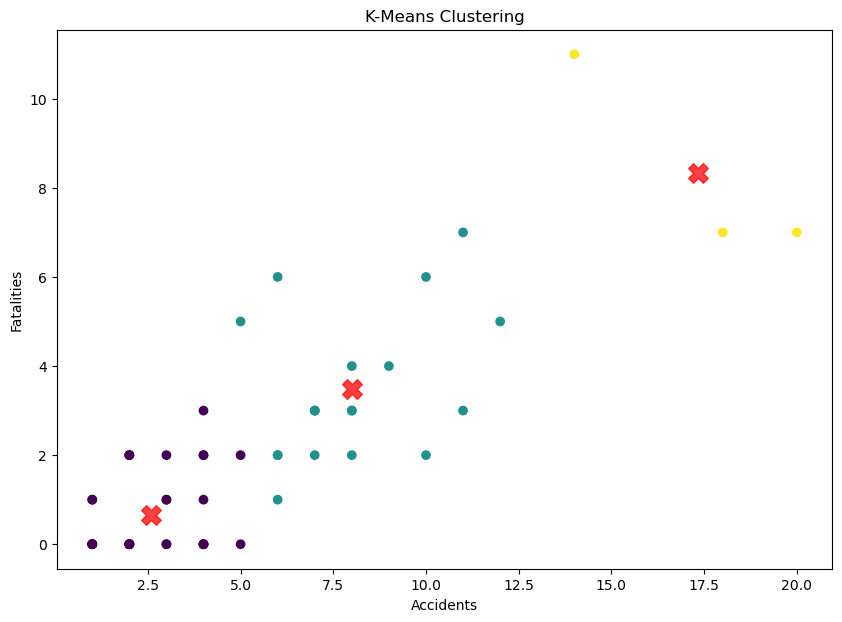

In [50]:
plt.figure(figsize=(10,7))
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y_kmeans)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=200, alpha=0.75, marker='X')
plt.xlabel('Accidents')
plt.ylabel('Fatalities')
plt.title('K-Means Clustering')
plt.show()

## Clustering in 3D

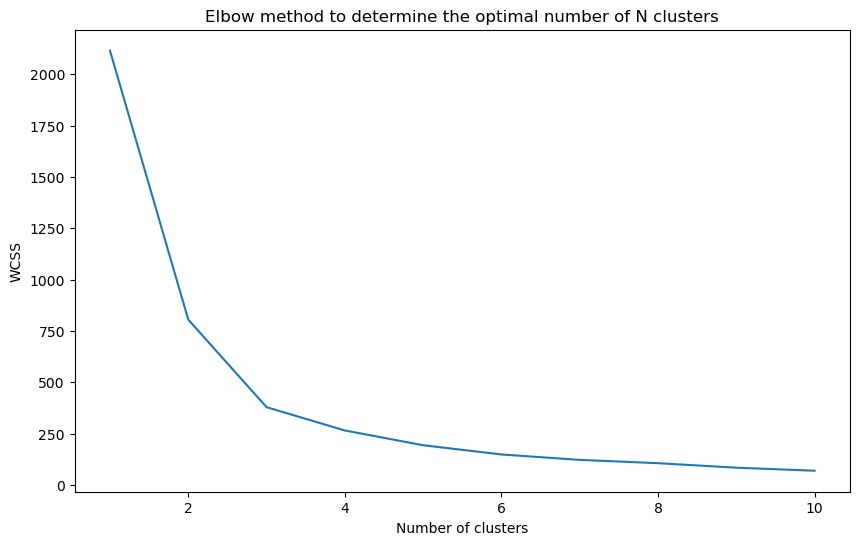

In [51]:
#x,y
X = new_df[['severe','fatal','accident']]
wcss = []

for i in range(1,11):
	kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
	kmeans.fit(X)
	wcss.append(kmeans.inertia_)


plt.figure(figsize=(10,6))
plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to determine the optimal number of N clusters')
plt.show()
#5 clusters

In [52]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

In [53]:
#to get the respective cluster number
new_df['Cluster'] = y_kmeans
new_df.head(20)

,city,accident,hospital,injury,fatal,severe,minor,regions,longitude,latitude,Cluster
0,Attard,10,6,6,6,7,1,4,14.4383,35.8928,1
1,Balzan,1,1,1,0,1,0,4,14.4533,35.8981,0
2,Birkirkara,12,9,9,5,12,0,2,14.4625,35.8967,1
3,Birżebbuġa,4,2,4,0,4,0,3,14.5281,35.8256,0
4,Buġibba,2,2,1,0,2,0,5,14.4110,35.9484,0
5,Cospicua,1,1,1,0,1,0,1,14.5222,35.8822,0
6,Fgura,7,6,7,3,7,0,1,14.5228,35.8725,1
7,Floriana,8,8,6,3,8,0,1,14.5058,35.8933,1
8,Gudja,4,4,4,0,4,1,3,14.5025,35.8483,0
9,Għajnsielem,3,3,3,1,3,1,6,14.2903,36.0269,0


In [54]:
score = silhouette_score(X,y_kmeans)
print(score)

0.5838343603242624


In [55]:
dbi = davies_bouldin_score(X,y_kmeans)
print(dbi)

0.5488014499572031


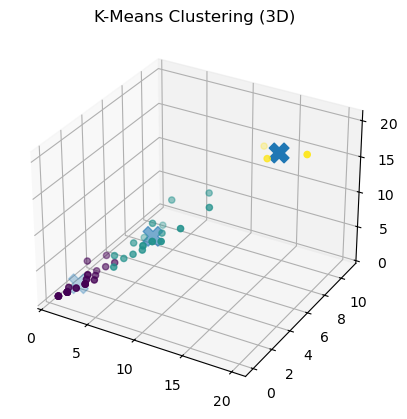

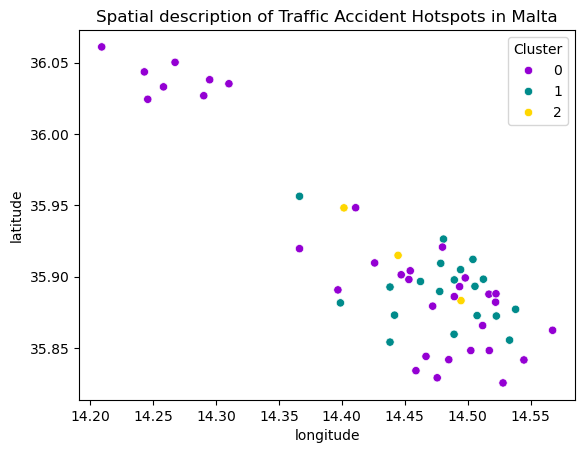

In [65]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_kmeans)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], marker='X',s=200)
#plt.xlabel('Severe')
#plt.ylabel('Minor')
ax.set_title('K-Means Clustering (3D)')
plt.show()

mycolors = ["darkviolet","darkcyan", "gold"]
malta_map = new_df[['longitude','latitude','Cluster']]
sns.scatterplot(data = malta_map, x = 'longitude', y = 'latitude', hue = 'Cluster',palette=mycolors).set(title='Spatial description of Traffic Accident Hotspots in Malta')
ax.set_title('lalala')
plt.show()

In [56]:
#creating subsets wrt. the clusters
zero_th_cluster = new_df[new_df['Cluster'] == 0]
first_th_cluster = new_df[new_df['Cluster'] == 1]
second_th_cluster = new_df[new_df['Cluster'] == 2]

In [57]:
#some stats on the 0th cluster
a = zero_th_cluster['city'].unique()
a_acc_min = min(zero_th_cluster['accident'])
a_acc_max = max(zero_th_cluster['accident'])
a_acc_mean = (zero_th_cluster['accident']).mean()
a_ftl_min = min(zero_th_cluster['fatal'])
a_ftl_max = max(zero_th_cluster['fatal'])
a_ftl_mean = (zero_th_cluster['fatal']).mean()
a_sev_min = min(zero_th_cluster['severe'])
a_sev_max = max(zero_th_cluster['severe'])
a_sev_mean = (zero_th_cluster['severe']).mean()
a_mnr_min = min(zero_th_cluster['minor'])
a_mnr_max = max(zero_th_cluster['minor'])
a_mnr_mean = (zero_th_cluster['minor']).mean()

In [58]:
#some stats on the 1st cluster
b = first_th_cluster['city'].unique()
b_acc_min = min(first_th_cluster['accident'])
b_acc_max = max(first_th_cluster['accident'])
b_acc_mean = (first_th_cluster['accident']).mean()
b_ftl_min = min(first_th_cluster['fatal'])
b_ftl_max = max(first_th_cluster['fatal'])
b_ftl_mean = (first_th_cluster['fatal']).mean()
b_sev_min = min(first_th_cluster['severe'])
b_sev_max = max(first_th_cluster['severe'])
b_sev_mean = (first_th_cluster['severe']).mean()
b_mnr_min = min(first_th_cluster['minor'])
b_mnr_max = max(first_th_cluster['minor'])
b_mnr_mean = (first_th_cluster['minor']).mean()

In [59]:
#some stats on the 2nd cluster
c = second_th_cluster['city'].unique()
c_acc_min = min(second_th_cluster['accident'])
c_acc_max = max(second_th_cluster['accident'])
c_acc_mean = (second_th_cluster['accident']).mean()
c_ftl_min = min(second_th_cluster['fatal'])
c_ftl_max = max(second_th_cluster['fatal'])
c_ftl_mean = (second_th_cluster['fatal']).mean()
c_sev_min = min(second_th_cluster['severe'])
c_sev_max = max(second_th_cluster['severe'])
c_sev_mean = (second_th_cluster['severe']).mean()
c_mnr_min = min(second_th_cluster['minor'])
c_mnr_max = max(second_th_cluster['minor'])
c_mnr_mean = (second_th_cluster['minor']).mean()

In [60]:
print(a)
print(len(a))
print("The min. no. of accidents was: ", a_acc_min)
print("The max. no. of accidents was: ", a_acc_max)
print("The mean no. of accidents was: ", a_acc_mean)
print("The min. no. of fatalities was: ", a_ftl_min)
print("The max. no. of fatalities was: ", a_ftl_max)
print("The mean no. of fatalities was: ", a_ftl_mean)
print("The min. no. of severities was: ", a_sev_min)
print("The max. no. of severities was: ", a_sev_max)
print("The mean no. of severities was: ", a_sev_mean)
print("The min. no. of minorities was: ", a_mnr_min)
print("The max. no. of minorities was: ", a_mnr_max)
print("The mean no. of minorities was: ", a_mnr_mean)
regions_0 = Counter(zero_th_cluster['regions'])
regions_0

['Balzan' 'Birżebbuġa' 'Buġibba' 'Cospicua' 'Gudja' 'Għajnsielem' 'Għarb'
 'Għaxaq' 'Iklin' 'Imqabba' 'Imtarfa' 'Kirkop' 'Lija' 'Marsaskala'
 'Marsaxlokk' 'Mosta' 'Mġarr' 'Nadur' 'Pietà' 'Qala' 'Qormi' 'Qrendi'
 'Sannat' 'Senglea' 'Swieqi' 'Tarxien' 'Ta’ Xbiex' 'Victoria' 'Vittoriosa'
 'Xagħra' 'Xewkija' 'Ħamrun' 'Żurrieq']
33
The min. no. of accidents was:  1
The max. no. of accidents was:  5
The mean no. of accidents was:  2.5757575757575757
The min. no. of fatalities was:  0
The max. no. of fatalities was:  3
The mean no. of fatalities was:  0.6666666666666666
The min. no. of severities was:  1
The max. no. of severities was:  5
The mean no. of severities was:  2.484848484848485
The min. no. of minorities was:  0
The max. no. of minorities was:  2
The mean no. of minorities was:  0.24242424242424243


Counter({3: 9, 6: 9, 2: 5, 4: 4, 5: 3, 1: 3})

In [61]:
print(b)
print(len(b))
print("The min. no. of accidents was: ", b_acc_min)
print("The max. no. of accidents was: ", b_acc_max)
print("The mean no. of acciedents was: ", b_acc_mean)
print("The min. no. of fatalities was: ", b_ftl_min)
print("The max. no. of fatalities was: ", b_ftl_max)
print("The mean no. of fatalities was: ", b_ftl_mean)
print("The min. no. of severities was: ", b_sev_min)
print("The max. no. of severities was: ", b_sev_max)
print("The mean no. of severities was: ", b_sev_mean)
print("The min. no. of minorities was: ", b_mnr_min)
print("The max. no. of minorities was: ", b_mnr_max)
print("The mean no. of minorities was: ", b_mnr_mean)
regions_1 = Counter(first_th_cluster['regions'])
regions_1

['Attard' 'Birkirkara' 'Fgura' 'Floriana' 'Gżira' 'Imsida' 'Luqa'
 'Mellieħa' 'Paola' 'Pembroke' 'Rabat' 'San Ġwann' 'Santa Venera'
 'Siġġiewi' 'Sliema' 'Valletta' 'Żabbar' 'Żebbuġ' 'Żejtun']
19
The min. no. of accidents was:  5
The max. no. of accidents was:  12
The mean no. of acciedents was:  8.0
The min. no. of fatalities was:  1
The max. no. of fatalities was:  7
The mean no. of fatalities was:  3.473684210526316
The min. no. of severities was:  5
The max. no. of severities was:  12
The mean no. of severities was:  7.578947368421052
The min. no. of minorities was:  0
The max. no. of minorities was:  3
The mean no. of minorities was:  0.7894736842105263


Counter({2: 7, 1: 6, 4: 4, 5: 1, 3: 1})

In [62]:
print(c)
print(len(c))
print("The min. no. of accidents was: ", c_acc_min)
print("The max. no. of accidents was: ", c_acc_max)
print("The mean no. of acciedents was: ", c_acc_mean)
print("The min. no. of fatalities was: ", c_ftl_min)
print("The max. no. of fatalities was: ", c_ftl_max)
print("The mean no. of fatalities was: ", c_ftl_mean)
print("The min. no. of severities was: ", c_sev_min)
print("The max. no. of severities was: ", c_sev_max)
print("The mean no. of severities was: ", c_sev_mean)
print("The min. no. of minorities was: ", c_mnr_min)
print("The max. no. of minorities was: ", c_mnr_max)
print("The mean no. of minorities was: ", c_mnr_mean)
regions_2 = Counter(second_th_cluster['regions'])
regions_2

['Marsa' 'Naxxar' 'Saint Paul’s Bay']
3
The min. no. of accidents was:  14
The max. no. of accidents was:  20
The mean no. of acciedents was:  17.333333333333332
The min. no. of fatalities was:  7
The max. no. of fatalities was:  11
The mean no. of fatalities was:  8.333333333333334
The min. no. of severities was:  12
The max. no. of severities was:  20
The mean no. of severities was:  16.0
The min. no. of minorities was:  1
The max. no. of minorities was:  3
The mean no. of minorities was:  2.0


Counter({5: 2, 1: 1})

### 3D Visualizations

In [63]:
clustered_groupings = new_df.groupby('Cluster', as_index=False)[['accident','fatal','severe','minor']].sum()
clustered_groupings.head(20)

,Cluster,accident,fatal,severe,minor
0,0,85,22,82,8
1,1,152,66,144,15
2,2,52,25,48,6


In [64]:
accidents = clustered_groupings["accident"]
fatalities = clustered_groupings["fatal"]
severities = clustered_groupings["severe"]
minorities = clustered_groupings["minor"]

In [67]:
mycolors = ["dodgerblue","yellowgreen", "coral"]
cluster_labels = ['c_0','c_1','c_2']
myexplode = [0,0,0]

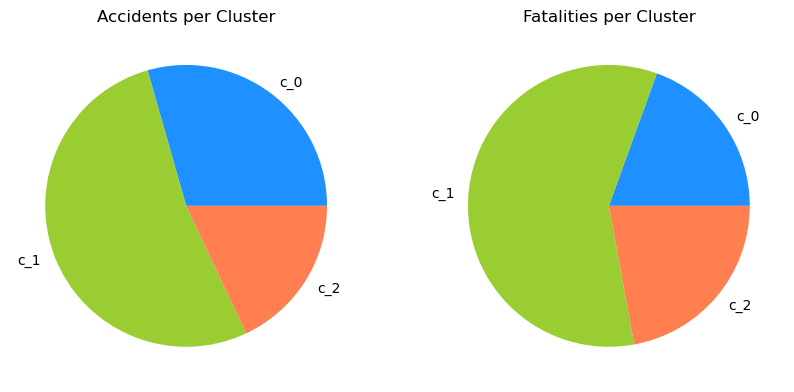

In [68]:
#No. of Accidents and No. of Fatalities per cluster
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.pie(accidents, labels = cluster_labels, explode = myexplode, colors = mycolors)
ax1.set_title("Accidents per Cluster")
ax2.pie(fatalities, labels = cluster_labels, explode = myexplode, colors = mycolors)
ax2.set_title("Fatalities per Cluster")
plt.show()

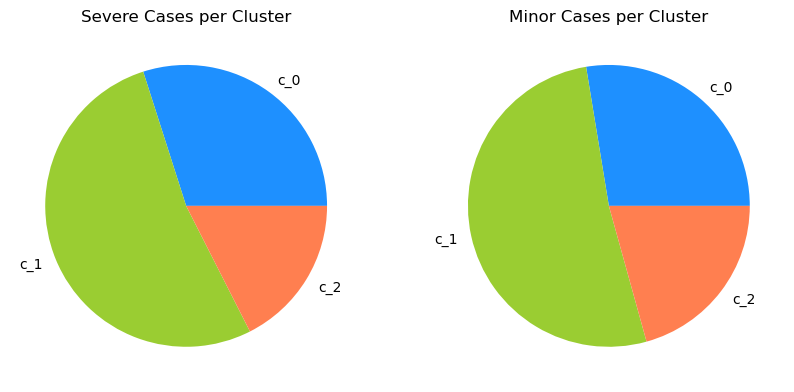

In [69]:
#No. of Severe and No. of Minor cases per cluster
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.pie(severities, labels = cluster_labels, explode = myexplode, colors = mycolors)
ax1.set_title("Severe Cases per Cluster")
ax2.pie(minorities, labels = cluster_labels, explode = myexplode, colors = mycolors)
ax2.set_title("Minor Cases per Cluster")
plt.show()

## Aggregating on Time

In [70]:
new_df = filtered_df.groupby('time', as_index=False)[['accident','hospital','injury','fatal',
'severe','minor']].sum()
new_df.head(20)

,time,accident,hospital,injury,fatal,severe,minor
0,0.0,1,1,1,0,1,0
1,100.0,3,2,1,3,3,0
2,130.0,1,1,1,0,1,1
3,200.0,2,1,2,0,2,0
4,430.0,2,2,2,2,2,0
5,500.0,2,2,2,2,2,0
6,510.0,1,0,1,0,1,0
7,520.0,1,1,1,1,1,0
8,525.0,2,1,1,2,2,0
9,530.0,8,7,8,2,8,0


## K-Means wrt. the time column

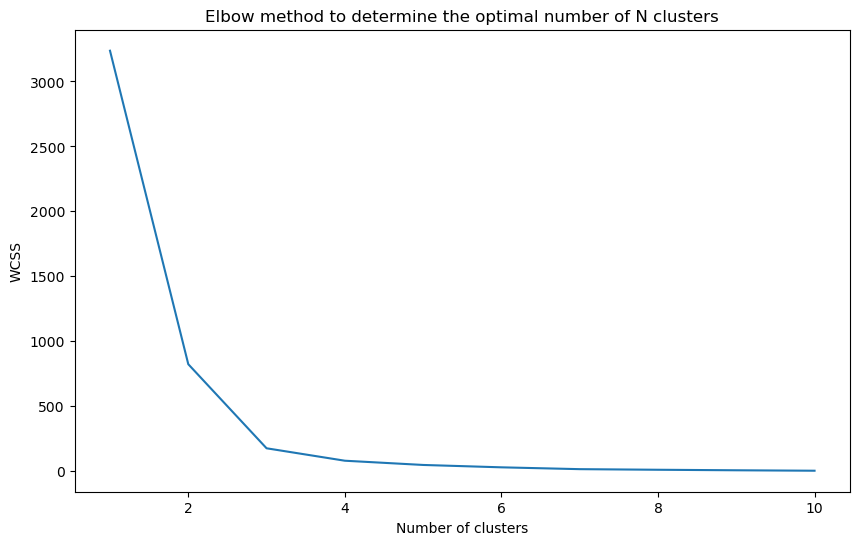

In [71]:
#x,y
X = new_df[['accident','severe']]
wcss = []

for i in range(1,11):
	kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
	kmeans.fit(X)
	wcss.append(kmeans.inertia_)


plt.figure(figsize=(10,6))
plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to determine the optimal number of N clusters')
plt.show() #3 clusters but do 2 clusters since compared to Michelle

In [72]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

#to get the respective cluster number
new_df['Cluster'] = y_kmeans
new_df.head(20)

,time,accident,hospital,injury,fatal,severe,minor,Cluster
0,0.0,1,1,1,0,1,0,2
1,100.0,3,2,1,3,3,0,2
2,130.0,1,1,1,0,1,1,2
3,200.0,2,1,2,0,2,0,2
4,430.0,2,2,2,2,2,0,2
5,500.0,2,2,2,2,2,0,2
6,510.0,1,0,1,0,1,0,2
7,520.0,1,1,1,1,1,0,2
8,525.0,2,1,1,2,2,0,2
9,530.0,8,7,8,2,8,0,0


In [73]:
#creating subsets wrt. the clusters
zero_th_cluster = new_df[new_df['Cluster'] == 0]
first_th_cluster = new_df[new_df['Cluster'] == 1]
second_th_cluster = new_df[new_df['Cluster'] == 2]

In [74]:
#some stats on the 0th cluster
a = zero_th_cluster['time'].unique()
a_acc_min = min(zero_th_cluster['accident'])
a_acc_max = max(zero_th_cluster['accident'])
a_acc_mean = (zero_th_cluster['accident']).mean()
a_ftl_min = min(zero_th_cluster['fatal'])
a_ftl_max = max(zero_th_cluster['fatal'])
a_ftl_mean = (zero_th_cluster['fatal']).mean()
a_sev_min = min(zero_th_cluster['severe'])
a_sev_max = max(zero_th_cluster['severe'])
a_sev_mean = (zero_th_cluster['severe']).mean()
a_mnr_min = min(zero_th_cluster['minor'])
a_mnr_max = max(zero_th_cluster['minor'])
a_mnr_mean = (zero_th_cluster['minor']).mean()

In [75]:
#some stats on the 1st cluster
b = first_th_cluster['time'].unique()
b_acc_min = min(first_th_cluster['accident'])
b_acc_max = max(first_th_cluster['accident'])
b_acc_mean = (first_th_cluster['accident']).mean()
b_ftl_min = min(first_th_cluster['fatal'])
b_ftl_max = max(first_th_cluster['fatal'])
b_ftl_mean = (first_th_cluster['fatal']).mean()
b_sev_min = min(first_th_cluster['severe'])
b_sev_max = max(first_th_cluster['severe'])
b_sev_mean = (first_th_cluster['severe']).mean()
b_mnr_min = min(first_th_cluster['minor'])
b_mnr_max = max(first_th_cluster['minor'])
b_mnr_mean = (first_th_cluster['minor']).mean()

In [76]:
print(a)
print(len(a))
print("The min. no. of accidents was: ", a_acc_min)
print("The max. no. of accidents was: ", a_acc_max)
print("The mean no. of accidents was: ", a_acc_mean)
print("The min. no. of fatalities was: ", a_ftl_min)
print("The max. no. of fatalities was: ", a_ftl_max)
print("The mean no. of fatalities was: ", a_ftl_mean)
print("The min. no. of severities was: ", a_sev_min)
print("The max. no. of severities was: ", a_sev_max)
print("The mean no. of severities was: ", a_sev_mean)
print("The min. no. of minorities was: ", a_mnr_min)
print("The max. no. of minorities was: ", a_mnr_max)
print("The mean no. of minorities was: ", a_mnr_mean)

[ 530.  730.  745.  800.  900.  930. 1015. 1100. 1130. 1300. 1315. 1330.
 1415. 1530. 1700. 1800. 1830. 1930. 2100. 2200.]
20
The min. no. of accidents was:  5
The max. no. of accidents was:  10
The mean no. of accidents was:  6.85
The min. no. of fatalities was:  0
The max. no. of fatalities was:  7
The mean no. of fatalities was:  2.15
The min. no. of severities was:  4
The max. no. of severities was:  9
The mean no. of severities was:  6.75
The min. no. of minorities was:  0
The max. no. of minorities was:  2
The mean no. of minorities was:  0.5


In [77]:
print(b)
print(len(b))
print("The min. no. of accidents was: ", b_acc_min)
print("The max. no. of accidents was: ", b_acc_max)
print("The mean no. of acciedents was: ", b_acc_mean)
print("The min. no. of fatalities was: ", b_ftl_min)
print("The max. no. of fatalities was: ", b_ftl_max)
print("The mean no. of fatalities was: ", b_ftl_mean)
print("The min. no. of severities was: ", b_sev_min)
print("The max. no. of severities was: ", b_sev_max)
print("The mean no. of severities was: ", b_sev_mean)
print("The min. no. of minorities was: ", b_mnr_min)
print("The max. no. of minorities was: ", b_mnr_max)
print("The mean no. of minorities was: ", b_mnr_mean)

[1303.2195122]
1
The min. no. of accidents was:  43
The max. no. of accidents was:  43
The mean no. of acciedents was:  43.0
The min. no. of fatalities was:  30
The max. no. of fatalities was:  30
The mean no. of fatalities was:  30.0
The min. no. of severities was:  33
The max. no. of severities was:  33
The mean no. of severities was:  33.0
The min. no. of minorities was:  6
The max. no. of minorities was:  6
The mean no. of minorities was:  6.0


In [78]:
#some stats on the 2nd cluster
c = second_th_cluster['time'].unique()
c_acc_min = min(second_th_cluster['accident'])
c_acc_max = max(second_th_cluster['accident'])
c_acc_mean = (second_th_cluster['accident']).mean()
c_ftl_min = min(second_th_cluster['fatal'])
c_ftl_max = max(second_th_cluster['fatal'])
c_ftl_mean = (second_th_cluster['fatal']).mean()
c_sev_min = min(second_th_cluster['severe'])
c_sev_max = max(second_th_cluster['severe'])
c_sev_mean = (second_th_cluster['severe']).mean()
c_mnr_min = min(second_th_cluster['minor'])
c_mnr_max = max(second_th_cluster['minor'])
c_mnr_mean = (second_th_cluster['minor']).mean()

In [79]:
print(c)
print(len(c))
print("The min. no. of accidents was: ", c_acc_min)
print("The max. no. of accidents was: ", c_acc_max)
print("The mean no. of acciedents was: ", c_acc_mean)
print("The min. no. of fatalities was: ", c_ftl_min)
print("The max. no. of fatalities was: ", c_ftl_max)
print("The mean no. of fatalities was: ", c_ftl_mean)
print("The min. no. of severities was: ", c_sev_min)
print("The max. no. of severities was: ", c_sev_max)
print("The mean no. of severities was: ", c_sev_mean)
print("The min. no. of minorities was: ", c_mnr_min)
print("The max. no. of minorities was: ", c_mnr_max)
print("The mean no. of minorities was: ", c_mnr_mean)

[   0.  100.  130.  200.  430.  500.  510.  520.  525.  545.  600.  630.
  700.  715.  815.  830.  845.  850.  915.  945. 1000. 1030. 1045. 1115.
 1200. 1215. 1230. 1245. 1345. 1430. 1445. 1515. 1537. 1545. 1600. 1620.
 1645. 1730. 1745. 1815. 1900. 1945. 2000. 2015. 2030. 2045. 2115. 2120.
 2215. 2230. 2300. 2330.]
52
The min. no. of accidents was:  1
The max. no. of accidents was:  4
The mean no. of acciedents was:  2.0961538461538463
The min. no. of fatalities was:  0
The max. no. of fatalities was:  4
The mean no. of fatalities was:  0.7692307692307693
The min. no. of severities was:  0
The max. no. of severities was:  4
The mean no. of severities was:  2.0384615384615383
The min. no. of minorities was:  0
The max. no. of minorities was:  2
The mean no. of minorities was:  0.25


In [80]:
score = silhouette_score(X,y_kmeans)
print(score)

0.6985237921668994


In [81]:
dbi = davies_bouldin_score(X,y_kmeans)
print(dbi)

0.29033419569893804


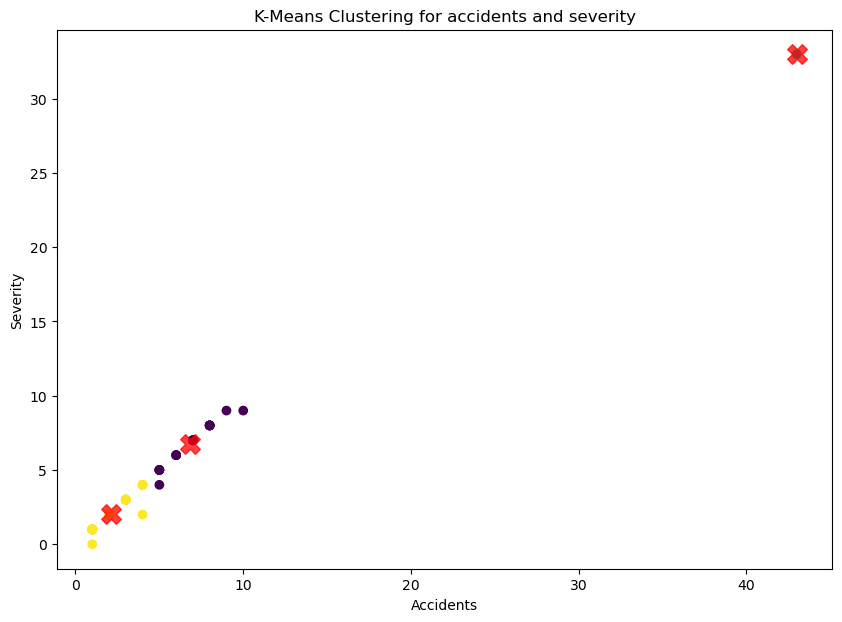

In [82]:
plt.figure(figsize=(10,7))
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y_kmeans)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=200, alpha=0.75, marker='X')
plt.xlabel('Accidents')
plt.ylabel('Severity')
plt.title('K-Means Clustering for accidents and severity')
plt.show()